In [1]:
# --- Make local package importable (robust for notebooks in subfolders) ---
import sys
from pathlib import Path

def add_src_to_path(pkg="quantlib", levels_up=3):
    here = Path.cwd().resolve()
    candidates = [here / "src"]
    # also check parents: ../src, ../../src, ...
    for i in range(1, levels_up+1):
        candidates.append(here.parents[i-1] / "src")
    for p in candidates:
        if (p / pkg / "__init__.py").exists():
            sys.path.insert(0, str(p))
            print(f"[OK] Added to sys.path: {p}")
            return p
    raise FileNotFoundError("Could not find src/quantlib/__init__.py relative to this notebook.")

add_src_to_path()


[OK] Added to sys.path: C:\Users\quantbase\Desktop\quant\src


WindowsPath('C:/Users/quantbase/Desktop/quant/src')

In [2]:
# --- bootstrap & imports ---
import sys, pathlib; sys.path.append(str(pathlib.Path.cwd() / "src"))
import importlib
from pathlib import Path
import numpy as np, pandas as pd
from quantlib import risk as qrisk
from quantlib import viz as qviz
#DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
#FIG_DIR = Path(r"C:\Users\quantbase\Desktop\quant\figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)


In [3]:
importlib.reload(qrisk)

<module 'quantlib.risk' from 'C:\\Users\\quantbase\\Desktop\\quant\\src\\quantlib\\risk.py'>

In [6]:
# --- 1) Configure root & today's run folder ----------------------------------
ROOT = Path(r"C:\Users\quantbase\Desktop\quant")
RUN_DATE = "30-09-2025"  # <Format "DD-MM-YYYY"
RUN_DIR  = ROOT / RUN_DATE


RAW = RUN_DIR / "data_raw"
INT = RUN_DIR / "data_int"
FIG = RUN_DIR / "figures"
for p in (RAW, INT, FIG):
    p.mkdir(parents=True, exist_ok=True) 

In [7]:
# --- load portfolio returns (or pick a symbol series instead) ---
r_port = pd.read_pickle(INT/"portfolio_returns.pkl").sort_index()


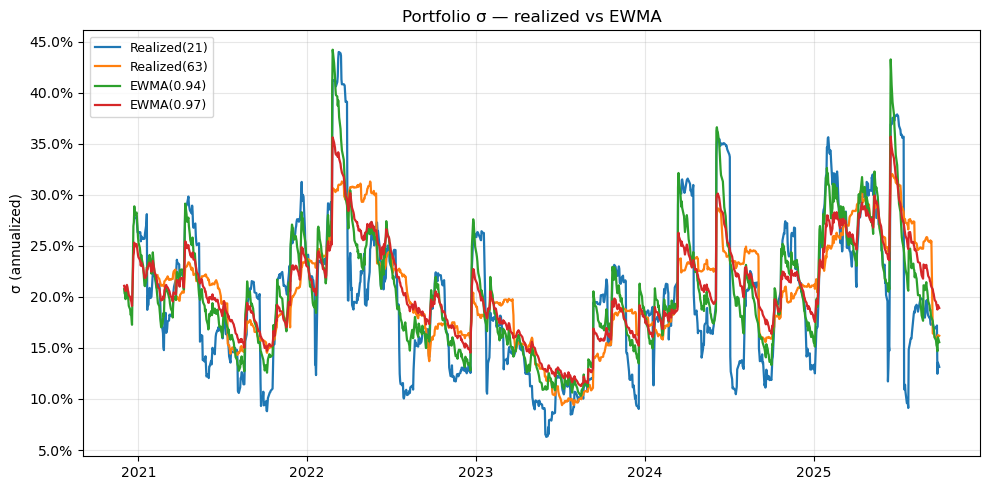

In [9]:
# --- realized & EWMA sigma (daily); compare on one axis (annualized) ---
sig21  = qrisk.realized_vol(r_port, 21)
sig63  = qrisk.realized_vol(r_port, 63)
sig252 = qrisk.realized_vol(r_port, 252)

ewma94 = qrisk.ewma_var_recursive(r_port, lam=0.94).pow(0.5)
ewma97 = qrisk.ewma_var_recursive(r_port, lam=0.97).pow(0.5)

qviz.plot_vol_series(
    {"Realized(21)": sig21, "Realized(63)": sig63, "EWMA(0.94)": ewma94, "EWMA(0.97)": ewma97},
    title="Portfolio σ — realized vs EWMA", annualize=True, save_path=FIG/"sigma_cmp.png"
)


In [10]:

sig21  = qrisk.realized_vol(r_port, 21)
sig63  = qrisk.realized_vol(r_port, 63)
sig252 = qrisk.realized_vol(r_port, 252)

sig_ewma_94 = qrisk.ewma_var_recursive(r_port, lam=0.94).pow(0.5)
sig_ewma_97 = qrisk.ewma_var_recursive(r_port, lam=0.97).pow(0.5)

(sig21.tail(), sig_ewma_94.tail())


(2025-09-23    0.010644
 2025-09-24    0.010830
 2025-09-25    0.007853
 2025-09-26    0.008545
 2025-09-29    0.008274
 Name: PORTFOLIO, dtype: float64,
 2025-09-23    0.009616
 2025-09-24    0.009519
 2025-09-25    0.009245
 2025-09-26    0.010108
 2025-09-29    0.009800
 dtype: float64)

In [11]:
#If you want the forward finite-window EWMA curves we built earlier, 
#reuse your helper and then call qviz.plot_vol_series.

In [12]:
# Future Returns (Forecasted RVol)

In [13]:
# --- 21d finite-window EWMA σ forecast for the next 20 business days ---


# r_target: choose your series — portfolio or one stock
# Example A (portfolio):
r_target = pd.read_pickle(INT/"portfolio_returns.pkl").sort_index()

# Example B (single stock):
# r_all = pd.read_pickle(r"C:\Users\quantbase\Desktop\quant\data_int\log_returns_daily.pkl").sort_index()
# r_target = r_all["BAJFINANCE"]

def forward_finite_ewma_forecast(r: pd.Series, window: int, lam: float, future_days: int) -> pd.Series:
    """Forward path: for k=1..future_days, compute EWMAσ over the most-recent `window`
       returns ending at t, t-1, t-2... (so you get a 1D forecast curve plotted into the future)."""
    r = pd.Series(r).astype(float).dropna()
    w = qrisk.ewma_weights(lam, window)          # α(1..n), sums to 1
    vals = []
    n = len(r)
    for k in range(future_days):                  # k=0 uses r[n-window:n], k=1 uses r[n-1-window:n-1], etc.
        end = n - k
        start = end - window
        if start < 0: break
        block = r.iloc[start:end].values
        if np.isnan(block).any():
            vals.append(np.nan)
        else:
            vals.append(np.sqrt(np.dot(w, block[::-1]**2)))  # α(1) aligns with most-recent return
    # future business-day index
    fut_idx = pd.date_range(r.index[-1] + pd.offsets.BDay(1), periods=len(vals), freq="B")
    return pd.Series(vals[::-1], index=fut_idx)  # chronological



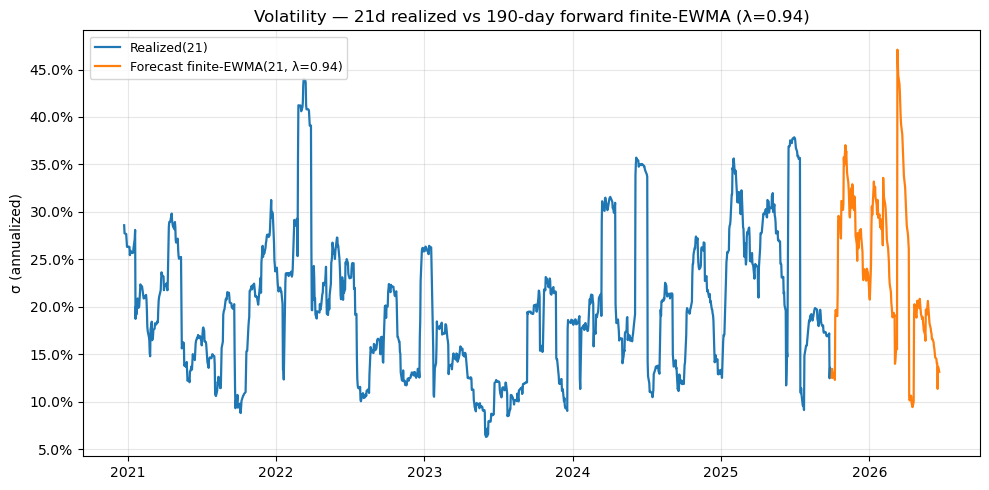

In [14]:
# ---- parameters ----
WINDOW = 21     # 21d "monthly" vol
LAMBDA = 0.94   # change to 0.97 if you prefer
FUTURE = 190     # forecast days 

# ---- plot (annualized) ----
sig_real_21 = qrisk.realized_vol(r_target, WINDOW)                    
sig_fwd_21  = forward_finite_ewma_forecast(r_target, WINDOW, LAMBDA, FUTURE)

qviz.plot_vol_series(
    {"Realized(21)": sig_real_21, f"Forecast finite-EWMA(21, λ={LAMBDA})": sig_fwd_21},
    title=f"Volatility — 21d realized vs {FUTURE}-day forward finite-EWMA (λ={LAMBDA})",
    annualize=True
)


In [17]:
# Example B (single stock):
r_all = pd.read_pickle(INT/"log_returns_daily.pkl").sort_index()

def forward_finite_ewma_forecast(r: pd.Series, window: int, lam: float, future_days: int) -> pd.Series:
    """Forward path: for k=1..future_days, compute EWMAσ over the most-recent `window`
       returns ending at t, t-1, t-2... (so you get a 1D forecast curve plotted into the future)."""
    r = pd.Series(r).astype(float).dropna()
    w = qrisk.ewma_weights(lam, window)          # α(1..n), sums to 1
    vals = []
    n = len(r)
    for k in range(future_days):                  # k=0 uses r[n-window:n], k=1 uses r[n-1-window:n-1], etc.
        end = n - k
        start = end - window
        if start < 0: break
        block = r.iloc[start:end].values
        if np.isnan(block).any():
            vals.append(np.nan)
        else:
            vals.append(np.sqrt(np.dot(w, block[::-1]**2)))  # α(1) aligns with most-recent return
    # future business-day index
    fut_idx = pd.date_range(r.index[-1] + pd.offsets.BDay(1), periods=len(vals), freq="B")
    return pd.Series(vals[::-1], index=fut_idx)  # chronological


In [20]:
r_target = r_all["ACI"]

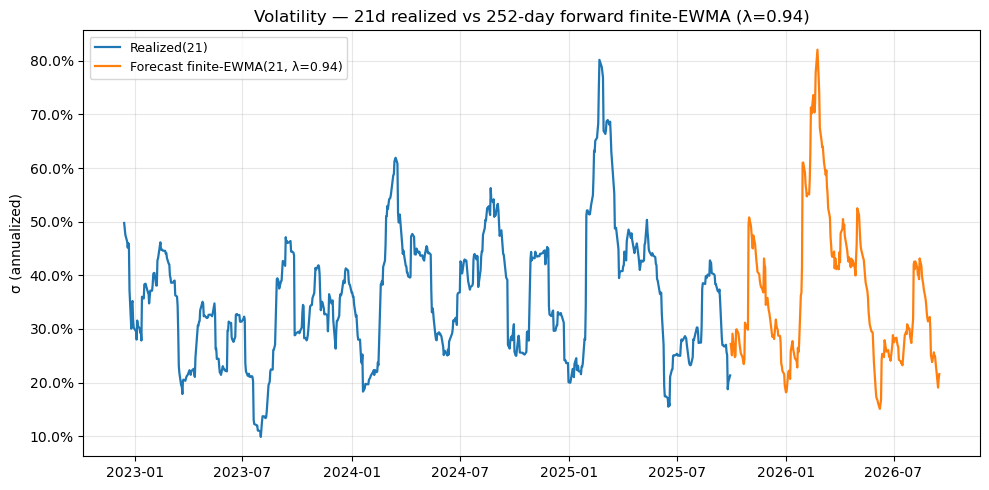

In [21]:
# ---- parameters ----
WINDOW = 21     # 21d "monthly" vol
LAMBDA = 0.94   # change to 0.97 if you prefer
FUTURE = 252     # forecast days 

# ---- plot (annualized) ----
sig_real_21 = qrisk.realized_vol(r_target, WINDOW)                    
sig_fwd_21  = forward_finite_ewma_forecast(r_target, WINDOW, LAMBDA, FUTURE)

qviz.plot_vol_series(
    {"Realized(21)": sig_real_21, f"Forecast finite-EWMA(21, λ={LAMBDA})": sig_fwd_21},
    title=f"Volatility — 21d realized vs {FUTURE}-day forward finite-EWMA (λ={LAMBDA})",
    annualize=True
)


In [103]:
# GARCH + EWMA

In [22]:
# params
WINDOW = 21          # realized vol window for context line
GARCH_WIN = 252      # re-fit lookback for the 'EWMA-style' GARCH
FUTURE = 252         # future business days

# realized σ (for context)
sig_real_21 = qrisk.realized_vol(r_target, WINDOW)

# EWMA finite-window forward (your existing helper)
def forward_finite_ewma_forecast(r: pd.Series, window: int, lam: float, future_days: int) -> pd.Series:
    r = pd.Series(r).astype(float).dropna()
    w = (1 - lam) * (lam ** np.arange(window-1, -1, -1)); w = w / w.sum()
    vals, n = [], len(r)
    for k in range(future_days):
        end = n - k; start = end - window
        if start < 0: break
        block = r.iloc[start:end].values
        vals.append(np.sqrt(np.dot(w, block[::-1]**2)) if not np.isnan(block).any() else np.nan)
    fut_idx = pd.date_range(r.index[-1] + pd.offsets.BDay(1), periods=len(vals), freq="B")
    return pd.Series(vals[::-1], index=fut_idx)



In [23]:
sig_fwd_ewma = forward_finite_ewma_forecast(r_target, window=21, lam=0.94, future_days=FUTURE)
sig_fwd_gw   = qrisk.garch11_forward_like_ewma(r_target, window=GARCH_WIN, horizon=FUTURE)

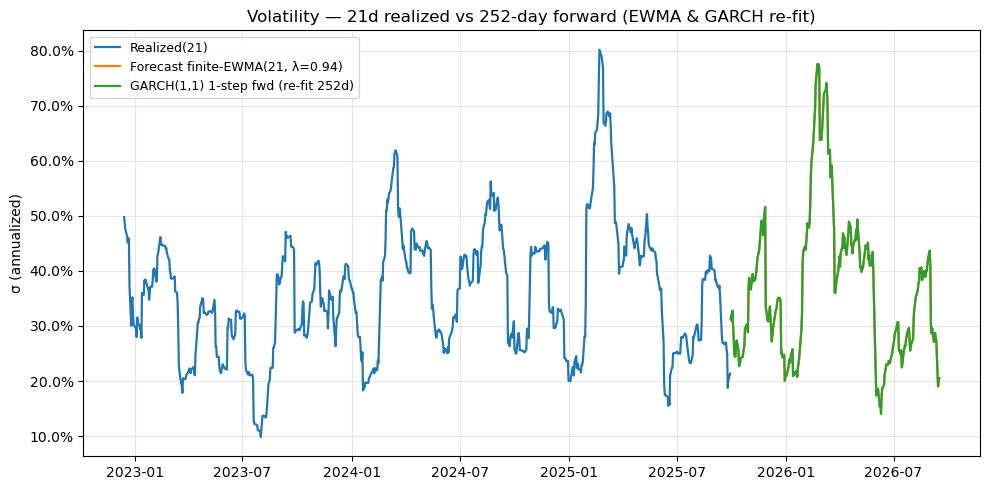

In [24]:
qviz.plot_vol_series(
    {
        "Realized(21)": sig_real_21,
        "Forecast finite-EWMA(21, λ=0.94)": sig_fwd_ewma,
        f"GARCH(1,1) 1-step fwd (re-fit {GARCH_WIN}d)": sig_fwd_ewma,
    },
    title=f"Volatility — 21d realized vs {FUTURE}-day forward (EWMA & GARCH re-fit)",
    annualize=True
)


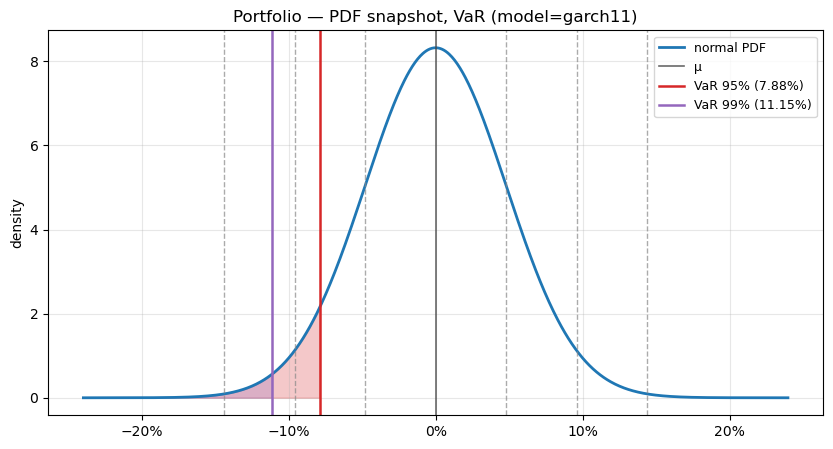

In [45]:
# get today's sigma from the chosen model
if VOL_MODEL == "ewma":
    sig_today = qrisk.ewma_var_recursive(r_port, lam=LAMBDA).pow(0.5).iloc[-1]
elif VOL_MODEL == "garch11":
    fit = qrisk.fit_garch11_normal(r_port); sig_today = float(fit["sigma"].iloc[-1])
elif VOL_MODEL == "arch":
    fit = qrisk.fit_garch11_normal(r_port); sig_today = float(fit["sigma"].iloc[-1])  # (beta≈0 if you forced ARCH upstream)
else:
    raise ValueError("VOL_MODEL must be ewma/garch11/arch")

mu_today = float(r_port.rolling(252).mean().iloc[-1]) if pd.notnull(r_port.rolling(252).mean().iloc[-1]) else 0.0

qviz.plot_var_pdf_snapshot(
    mu=mu_today,
    sigma=float(sig_today),
    alphas=(0.95, 0.99),
    dist="normal",
    title=f"Portfolio — PDF snapshot, VaR (model={VOL_MODEL})",
    save_path=FIG_DIR/f"var_snapshot_{VOL_MODEL}.png",
)
